# Multiple Input and Output Channels

While we have described the multiple channels
that comprise each image (e.g. color images have the standard RGB channels
to indicate the amount of red, green and blue),
until now, we simplified all of our numerical examples
by working with just a single input and a single output channel.
This has allowed us to think of our inputs, convolutional kernels,
and outputs each as two-dimensional arrays.

When we add channels into the mix,
our inputs and hidden representations
both become three-dimensional arrays.
For example, each RGB input image has shape $3\times h\times w$.
We refer to this axis, with a size of 3, as the channel dimension.
In this section, we will take a deeper look
at convolution kernels with multiple input and multiple output channels.

## Multiple Input Channels

When the input data contains multiple channels,
we need to construct a convolution kernel
with the same number of input channels as the input data,
so that it can perform cross-correlation with the input data.
Assuming that the number of channels for the input data is $c_i$,
the number of input channels of the convolution kernel also needs to be $c_i$. If our convolution kernel's window shape is $k_h\times k_w$,
then when $c_i=1$, we can think of our convolution kernel
as just a two-dimensional array of shape $k_h\times k_w$.

However, when $c_i>1$, we need a kernel
that contains an array of shape $k_h\times k_w$ *for each input channel*. Concatenating these $c_i$ arrays together
yields a convolution kernel of shape $c_i\times k_h\times k_w$.
Since the input and convolution kernel each have $c_i$ channels,
we can perform a cross-correlation operation
on the two-dimensional array of the input
and the two-dimensional kernel array of the convolution kernel
for each channel, adding the $c_i$ results together
(summing over the channels)
to yield a two-dimensional array.
This is the result of a two-dimensional cross-correlation
between multi-channel input data and
a *multi-input channel* convolution kernel.

In the figure below, we demonstrate an example
of a two-dimensional cross-correlation with two input channels.
The shaded portions are the first output element
as well as the input and kernel array elements used in its computation:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.



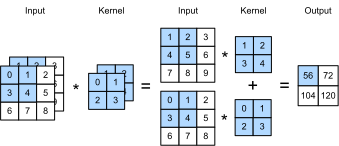

In [1]:
from IPython.display import SVG, Image
SVG(filename="../img/conv_multi_in.svg")

To make sure we really understand what's going on here,
we can implement cross-correlation operations with multiple input channels ourselves.
Notice that all we are doing is performing one cross-correlation operation
per channel and then adding up the results using the `add_n` function.

In [2]:
import sys
sys.path.insert(0, '..')

import d2l
import torch

In [3]:
def corr2d_multi_in(X, K):
    # First, traverse along the 0th dimension (channel dimension) of X and K. 
    # Then, add them together by using python sum() function
    # which takes in a list as an argument
    return sum([d2l.corr2d(x, k) for x, k in zip(X, K)])

We can construct the input array `X` and the kernel array `K`
corresponding to the values in the above diagram
to validate the output of the cross-correlation operation.

In [4]:
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
                  [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]],
                  [[1, 2], [3, 4]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## Multiple Output Channels

Regardless of the number of input channels,
so far we always ended up with one output channel.
However, as we discussed earlier,
it turns out to be essential to have multiple channels at each layer.
In the most popular neural network architectures,
we actually increase the channel dimension
as we go higher up in the neural network,
typically downsampling to trade off spatial resolution
for greater *channel depth*.
Intuitively, you could think of each channel
as responding to some different set of features.
Reality is a bit more complicated than the most naive intepretations of this intuition since representations aren't learned independent but are rather optimized to be jointly useful.
So it may not be that a single channel learns an edge detector but rather that some direction in channel space corresponds to detecting edges.


Denote by $c_i$ and $c_o$ the number
of input and output channels, respectively,
and let $k_h$ and $k_w$ be the height and width of the kernel.
To get an output with multiple channels,
we can create a kernel array
of shape $c_i\times k_h\times k_w$
for each output channel.
We concatenate them on the output channel dimension,
so that the shape of the convolution kernel
is $c_o\times c_i\times k_h\times k_w$.
In cross-correlation operations,
the result on each output channel is calculated
from the convolution kernel corresponding to that output channel
and takes input from all channels in the input array.

We implement a cross-correlation function
to calculate the output of multiple channels as shown below.

In [5]:
def corr2d_multi_in_out(X, K):
    # Traverse along the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are merged
    # together using the stack function
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=0)

We construct a convolution kernel with 3 output channels
by concatenating the kernel array `K` with `K+1`
(plus one for each element in `K`) and `K+2`.

In [6]:
K = torch.stack([K, K + 1, K + 2], dim=0)
K.shape

torch.Size([3, 2, 2, 2])

Below, we perform cross-correlation operations
on the input array `X` with the kernel array `K`.
Now the output contains 3 channels.
The result of the first channel is consistent
with the result of the previous input array `X`
and the multi-input channel,
single-output channel kernel.

In [7]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## $1\times 1$ Convolutional Layer

At first, a $1 \times 1$ convolution, i.e. $k_h = k_w = 1$,
doesn't seem to make much sense.
After all, a convolution correlates adjacent pixels.
A $1 \times 1$ convolution obviously doesn't.
Nonetheless, they are popular operations that are sometimes included
in the designs of complex deep networks.
Let's see in some detail what it actually does.

Because the minimum window is used,
the $1\times 1$ convolution loses the ability
of larger convolutional layers
to recognize patterns consisting of interactions
among adjacent elements in the height and width dimensions.
The only computation of the $1\times 1$ convolution occurs
on the channel dimension.

The figure below shows the cross-correlation computation
using the $1\times 1$ convolution kernel
with 3 input channels and 2 output channels.
Note that the inputs and outputs have the same height and width.
Each element in the output is derived
from a linear combination of elements *at the same position*
in the input image.
You could think of the $1\times 1$ convolutional layer
as constituting a fully-connected layer applied at every single pixel location
to transform the c_i corresponding input values into c_o output values.
Because this is still a convolutional layer,
the weights are tied across pixel location
Thus the $1\times 1$ convolutional layer requires $c_o\times c_i$ weights
(plus the bias terms).

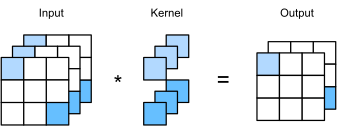

In [8]:
Image(filename="../img/conv_1x1.png")

Let's check whether this works in practice:
we implement the $1 \times 1$ convolution
using a fully-connected layer.
The only thing is that we need to make some adjustments
to the data shape before and after the matrix multiplication.

In [9]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.mm(K, X)  # Matrix multiplication in the fully connected layer
    return Y.reshape((c_o, h, w))

When performing $1\times 1$ convolution,
the above function is equivalent to the previously implemented cross-correlation function `corr2d_multi_in_out`.
Let's check this with some reference data.

In [10]:
X = torch.randn(size=(3, 3, 3))
K = torch.randn(size=(2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

(Y1 - Y2).norm().item() < 1e-6

True

## Summary

* Multiple channels can be used to extend the model parameters of the convolutional layer.
* The $1\times 1$ convolutional layer is equivalent to the fully-connected layer, when applied on a per pixel basis.
* The $1\times 1$ convolutional layer is typically used to adjust the number of channels between network layers and to control model complexity.

## Exercises

1. Assume that we have two convolutional kernels of size $k_1$ and $k_2$ respectively (with no nonlinearity in between).
    * Prove that the result of the operation can be expressed by a single convolution.
    * What is the dimensionality of the equivalent single convolution?
    * Is the converse true?
1. Assume an input shape of $c_i\times h\times w$ and a convolution kernel with the shape $c_o\times c_i\times k_h\times k_w$, padding of $(p_h, p_w)$, and stride of $(s_h, s_w)$.
    * What is the computational cost (multiplications and additions) for the forward computation?
    * What is the memory footprint?
    * What is the memory footprint for the backward computation?
    * What is the computational cost for the backward computation?
1. By what factor does the number of calculations increase if we double the number of input channels $c_i$ and the number of output channels $c_o$? What happens if we double the padding?
1. If the height and width of the convolution kernel is $k_h=k_w=1$, what is the complexity of the forward computation?
1. Are the variables `Y1` and `Y2` in the last example of this section exactly the same? Why?
1. How would you implement convolutions using matrix multiplication when the convolution window is not $1\times 1$?


